# RoBERTa Base GPT2 Detector (on GPT2)

Running on GPT2 Output Dataset, trying to reproduce the result of OpenAI.

## Configuration

Setup parameters for the notebook

In [1]:
from pathlib import Path

projectDirectory = Path(Path.cwd().parent.parent.parent)
detectorDirectory = Path.cwd()
dataDirectory = Path(projectDirectory, "data", "GPT2-Output")

config = {
    "BatchSize": 8
}

print(projectDirectory)
print(detectorDirectory)

d:\Git-Project\GPT-Sentinel
d:\Git-Project\GPT-Sentinel\src\model\baseline


## Setup

Download the trained model from OpenAI, prepare all components required to run the model

**Note**: According to https://github.com/openai/gpt-2-output-dataset/issues/28, it is required to use
* `transformers == 2.9.1`
* `tokenizers == 0.7.0`

> WARNING: to install these two specific version, you MUST have your python as version of 3.8
>
> Because
> 1. pip does not have pre-compiled wheel for tokenizers v0.7.0 for python 3.9+
> 2. to compile tokenizer, you need to download rust compiler
> 3. tokenizer 0.7.0's Rust source code is using deprecated feature in Rust language, which is NOT supported (error, not warning) by latest rust compiler
> 4. So you can't install tokenizer 0.7.0 on the environment if you are not using python 3.8


to make things work. Installing later versions of transformer leads to error in loading weight file.

In [2]:
import torch
import subprocess

from transformers import RobertaForSequenceClassification, RobertaTokenizer
state_path = Path(projectDirectory, "result", "cache", "detector-base.pt")
if not state_path.is_file():
    subprocess.run(["wget", "https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt"])

state = torch.load(state_path)
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", truncation=True, max_length=510)

model.load_state_dict(state["model_state_dict"])
model.to("cuda")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## Download GPT-2 Output Dataset for Test

Following code from https://github.com/openai/gpt-2-output-dataset/blob/master/download_dataset.py

We will download small dataset from OpenAI

In [3]:
import os
import requests
from tqdm import tqdm

if not dataDirectory.exists():
    os.makedirs(dataDirectory)

file_paths = [
    Path(dataDirectory, "small-117M.test.jsonl"),
    Path(dataDirectory, "small-117M-k40.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl"),
]

is_downloaded = all([p.exists() for p in file_paths])
if is_downloaded: print("Dataset already downloaded.")

Dataset already downloaded.


In [4]:
if not is_downloaded:
    for ds in ['webtext', 'small-117M',  'small-117M-k40',
               'medium-345M', 'medium-345M-k40',
               'large-762M',  'large-762M-k40',
               'xl-1542M',    'xl-1542M-k40']:
        for split in ['test']:
            filename = ds + "." + split + '.jsonl'
            r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

            with open(os.path.join(dataDirectory, filename), 'wb') as f:
                file_size = int(r.headers["content-length"])
                chunk_size = 1000
                with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
                    # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                    for chunk in r.iter_content(chunk_size=chunk_size):
                        f.write(chunk)
                        pbar.update(chunk_size)
else:
    print("Dataset already downloaded, this block is skipped.")

Dataset already downloaded, this block is skipped.


## Define Dataset and Dataloader

Define dataset and dataloader for the GPT2-output dataset.

In [5]:
import torch.utils.data
import json


class GPT2_OutputDataset(torch.utils.data.Dataset):
    def __init__(self, gpt_jsonl_path: Path, human_jsonl_path: Path):
        super().__init__()
        assert gpt_jsonl_path.exists()
        assert human_jsonl_path.exists()

        with open(human_jsonl_path, "r") as f:
            human_texts = [json.loads(line) for line in tqdm(f.read().strip().splitlines(), desc="Loading Human text", ncols=100)]

        with open(gpt_jsonl_path, "r") as f:
            gpt_texts = [json.loads(line) for line in tqdm(f.read().strip().splitlines(), desc="Loading GPT text", ncols=100)]

        # We need to sanitize the dataset since some of them are invalid (e.g. #255123 in small-117M.test.jsonl is empty)
        gpt_texts = [entity for entity in gpt_texts if len(entity["text"]) > 0]
        human_texts = [entity for entity in human_texts if len(entity["text"]) > 0]

        self.human_dict = {human_text["id"] : human_text for human_text in human_texts}
        self.gpt_dict = {gpt_text["id"]: gpt_text for gpt_text in gpt_texts}

        self.data = [(human_text, 0) for human_text in human_texts] + [(gpt_text, 1) for gpt_text in gpt_texts]
        self.length = len(self.data)
        print("<All data loaded>")

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        entry =  self.data[index]
        return entry[0]["text"], entry[1]

    def retrieve_id(self, text_id):
        assert text_id in self.human_dict
        assert text_id in self.gpt_dict
        return self.human_dict[text_id]["text"], self.gpt_dict[text_id]["text"]


In [6]:
small_dataset_rand = GPT2_OutputDataset(
    Path(dataDirectory, "small-117M.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

medium_dataset_rand = GPT2_OutputDataset(
    Path(dataDirectory, "medium-345M.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

large_dataset_rand = GPT2_OutputDataset(
    Path(dataDirectory, "large-762M.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

extra_large_dataset_rand = GPT2_OutputDataset(
    Path(dataDirectory, "xl-1542M.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 51406.58it/s]


<All data loaded>


Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 43451.32it/s]


<All data loaded>


Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 53293.89it/s]


<All data loaded>


Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 48244.88it/s]

<All data loaded>


## Evaluation (1) - Random Sampling Strategy

Run test on GPT2 pretrained model, see the test accuaracy

In [7]:
def test(testDataset: torch.utils.data.Dataset):
    realReal, falseReal, realFake, falseFake = 0, 0, 0, 0
    progressBar = tqdm(total=len(testDataset), desc="Test", ncols=100)

    for i, (text, label) in enumerate(testDataset):
        # encode
        tokens = tokenizer.encode(text, max_length=512)
        tokens = tokens[:tokenizer.max_len - 2]
        tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
        mask = torch.ones_like(tokens)

        # forward propagation
        with torch.no_grad():
            logits = model(tokens.to("cuda"), attention_mask=mask.to("cuda"))[0]
            probs = logits.softmax(dim=-1)

        # update statistics
        fake, real = probs.detach().cpu().flatten().numpy().tolist()

        true_label = "real" if label == 0 else "fake"
        pred_label = "real" if real > fake else "fake"

        if true_label == "real" and pred_label == "real":
            realReal += 1
        elif true_label == "real" and pred_label == "fake":
            falseFake += 1
        elif true_label == "fake" and pred_label == "real":
            falseReal += 1
        elif true_label == "fake" and pred_label == "fake":
            realFake += 1

        # update progress
        progressBar.set_postfix(accuracy="{0:.4%}".format((realReal + realFake) / (i + 1)))
        progressBar.update()

    return realReal, falseFake, falseReal, realFake


In [8]:
confusion_matrix_cache_path = Path(projectDirectory, "result", "cache", "baseline_test_gpt2_random_sample.json")
if confusion_matrix_cache_path.exists():
    with open(confusion_matrix_cache_path, "r") as f:
        confusion_matrices_rand = json.load(f)
else:
    confusion_matrices_rand = {
        "small": test(small_dataset_rand),
        "medium": test(medium_dataset_rand),
        "large": test(large_dataset_rand),
        "extra_large": test(extra_large_dataset_rand)
    }
    with open(confusion_matrix_cache_path, "w") as f:
        json.dump(confusion_matrices_rand, f)

Test: 100%|████████████████████████████████| 10000/10000 [04:32<00:00, 36.71it/s, accuracy=93.1000%]


### Analysis and Visualization

Here, we want to plot the confusion matrix of each classification result and find the trend of accuracy as the number of argument increases

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def confusion_matrix(tp, fn, fp, tn, title=""):
    plt.figure(dpi=200)
    plt.imshow(np.array([[tp, fn], [fp, tn]]), cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    plt.clim(0, 5000)
    plt.title(title)
    plt.xticks([0, 1], ['Real', 'Generated'])
    plt.yticks([0, 1], ['Real', 'Generated'])
    # put values in the boxes
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(np.array([[tp, fn], [fp, tn]])[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if np.array([[tp, fn], [fp, tn]])[i, j] > (tp + tn + fp + fn) / 3 else "black")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
confusion_matrix(*confusion_matrices_rand["small"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n small (117M) model with random sampling method")

In [ ]:
confusion_matrix(*confusion_matrices_rand["medium"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n medium (345M) model with random sampling method")

In [ ]:
confusion_matrix(*confusion_matrices_rand["large"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n large (762M) model with random sampling method")

In [ ]:
confusion_matrix(*confusion_matrices_rand["extra_large"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n extra large (1542M) model with random sampling method")

In [ ]:
# Combined confusion matrix
def combined_confusion_mat(confusion_matrices, output):
    figs, axes = plt.subplots(nrows=2, ncols=2, dpi=200)
    for i, key in enumerate(["small", "medium", "large", "extra_large"]):
        ax: plt.Axes = axes.flat[i]
        tp, fn, fp, tn = confusion_matrices[key]
        im = ax.imshow(np.array([[tp, fn], [fp, tn]]), cmap=plt.cm.Blues, interpolation='nearest', vmin=0, vmax=5000)
        ax.set_xticks([0, 1], ['Real', 'Generated'])
        ax.set_yticks([0, 1], ['Real', 'Generated'])
        # put values in the boxes
        for i in range(2):
            for j in range(2):
                ax.text(j, i, format(np.array([[tp, fn], [fp, tn]])[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if np.array([[tp, fn], [fp, tn]])[i, j] > (tp + tn + fp + fn) / 3 else "black")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(key.capitalize() + " GPT-2 Model")
    cbar_ax = figs.add_axes([1.3, 0.15, 0.05, 1])
    figs.colorbar(im, cax=cbar_ax)
    # cbar_ax.clim(0, 5000)
    figs.subplots_adjust(left=0.1, bottom=0.1, right=1.2, top=1.2, wspace=0.4, hspace=0.4)
    plt.show()
    figs.savefig(Path(projectDirectory, "result/figures", output), bbox_inches = 'tight')

In [ ]:
combined_confusion_mat(confusion_matrices_rand, "confusion_mat_gpt2_baseline_random_combined.png")

Now, draw a plot that concludes the trend of precision and recall rate where x axis is the number of parameters in language model (in Million)

## Evaluation (2) - K40 Sampling Strategy

In [10]:
small_dataset_topk = GPT2_OutputDataset(
    Path(dataDirectory, "small-117M-k40.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

medium_dataset_topk = GPT2_OutputDataset(
    Path(dataDirectory, "medium-345M-k40.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

large_dataset_topk = GPT2_OutputDataset(
    Path(dataDirectory, "large-762M-k40.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

extra_large_dataset_topk = GPT2_OutputDataset(
    Path(dataDirectory, "xl-1542M-k40.test.jsonl"),
    Path(dataDirectory, "webtext.test.jsonl")
)

Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 85554.39it/s]


<All data loaded>


Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 78552.37it/s]


<All data loaded>


Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 73573.18it/s]

<All data loaded>

Loading GPT text: 100%|██████████████████████████████████████| 5000/5000 [00:00<00:00, 83971.39it/s]

<All data loaded>


In [11]:
confusion_matrix_cache_path = Path(projectDirectory, "result", "cache", "baseline_test_gpt2_k40_sample.json")
if confusion_matrix_cache_path.exists():
    with open(confusion_matrix_cache_path, "r") as f:
        confusion_matrices_topk = json.load(f)
else:
    confusion_matrices_topk = {
        "small": test(small_dataset_topk),
        "medium": test(medium_dataset_topk),
        "large": test(large_dataset_topk),
        "extra_large": test(extra_large_dataset_topk)
    }
    with open(confusion_matrix_cache_path, "w") as f:
        json.dump(confusion_matrices_topk, f)

Test: 100%|████████████████████████████████| 10000/10000 [04:21<00:00, 38.29it/s, accuracy=94.9800%]


In [ ]:
confusion_matrix(*confusion_matrices_topk["small"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n small (117M) model with top-k sampling method (k=40)")

In [ ]:
confusion_matrix(*confusion_matrices_topk["medium"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n medium (345M) model with top-k sampling method (k=40)")

In [ ]:
confusion_matrix(*confusion_matrices_topk["large"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n large (762M) model with top-k sampling method (k=40)")

In [ ]:
confusion_matrix(*confusion_matrices_topk["extra_large"], "Confusion Matrix for GPT2 Detector on GPT2-output test dataset\n extra large (1542M) model with top-k sampling method (k=40)")

In [ ]:
combined_confusion_mat(confusion_matrices_topk, "confusion_mat_gpt2_baseline_k40_combined.png")

### Draw Accuracy curve and False Positive Curve

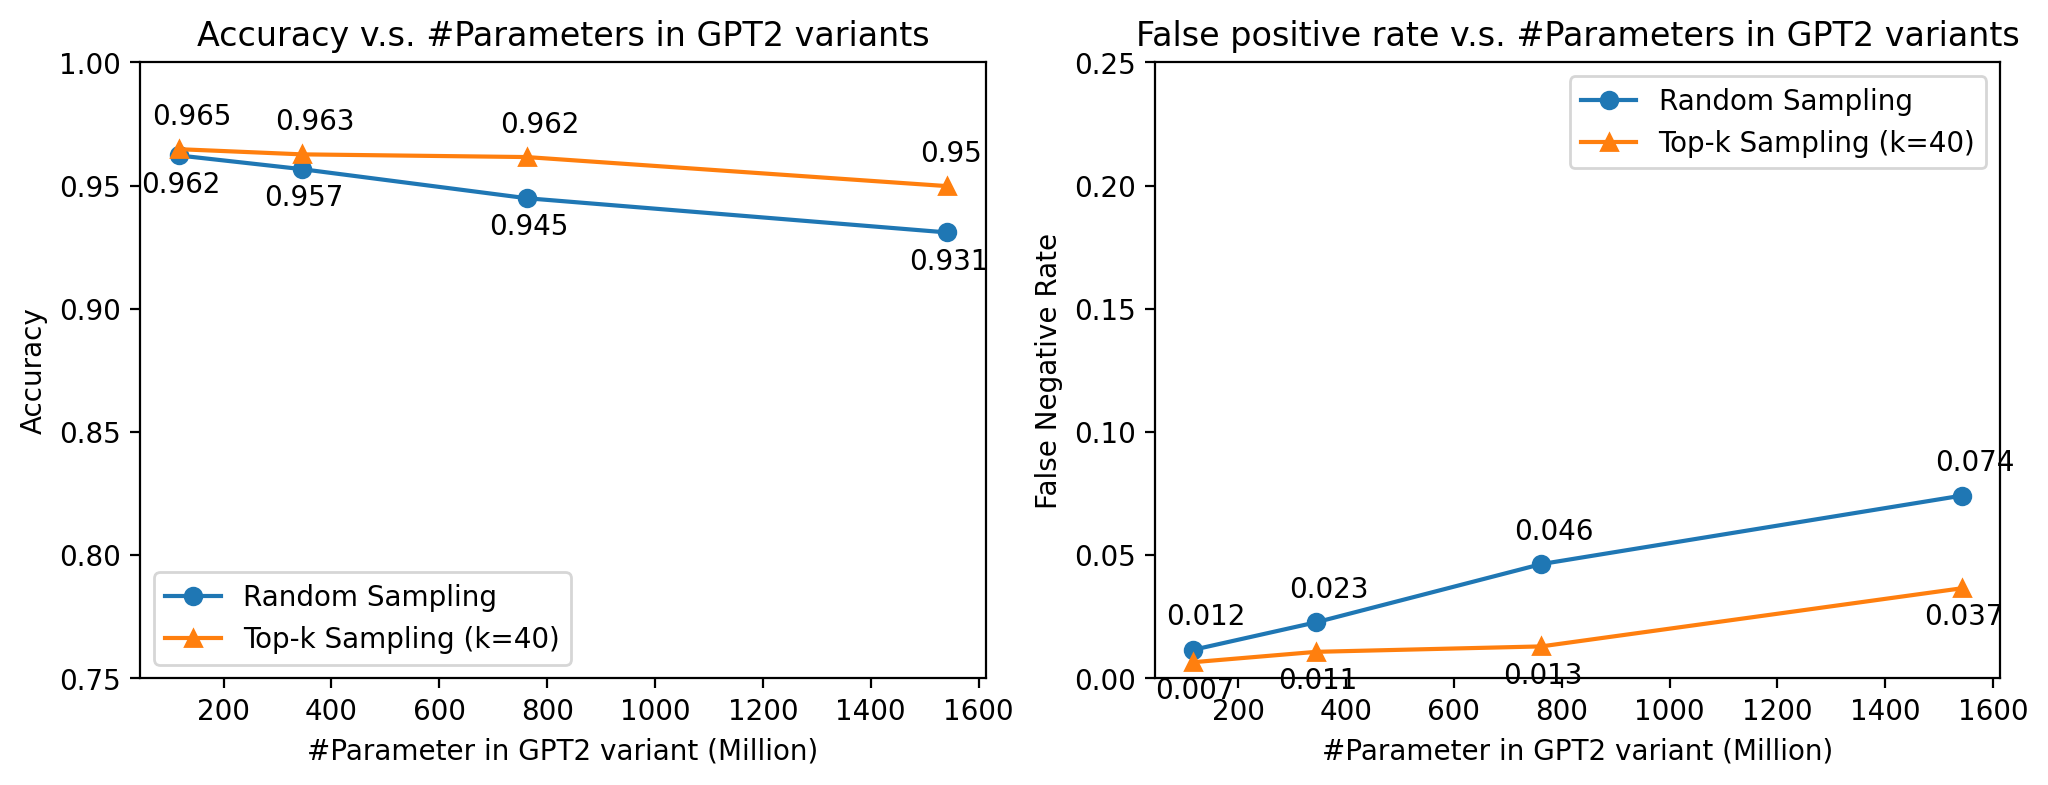

In [13]:
import matplotlib.pyplot as plt

random_sample_mats_path = Path(projectDirectory, "result", "cache", "baseline_test_gpt2_random_sample.json")
topk_sample_mats_path = Path(projectDirectory, "result", "cache", "baseline_test_gpt2_k40_sample.json")

with open(random_sample_mats_path, "r") as f: random_sample_mats = json.load(f)
with open(topk_sample_mats_path, "r") as f: topk_sample_mats = json.load(f)

params = [117, 345, 762, 1542]
random_accuracy, random_false_pos = [], []
topk_accuracy, topk_false_pos = [], []
for key in ["small", "medium", "large", "extra_large"]:
    # positive - fake (by GPT), negative - real (by human)
    tn, fp, fn, tp = random_sample_mats[key]
    random_accuracy.append((tp + tn) / (tp + fn + fp + tn))
    random_false_pos.append(fn / (tp + fn))
    tn, fp, fn, tp = topk_sample_mats[key]
    topk_accuracy.append((tp + tn) / (tp + fn + fp + tn))
    topk_false_pos.append(fn / (tp + fn))

plt.figure(dpi=200, figsize=(12, 4))
plt.subplot(121)
plt.title("Accuracy v.s. #Parameters in GPT2 variants")
plt.plot(params, random_accuracy, label="Random Sampling", marker="o")
plt.plot(params, topk_accuracy, label="Top-k Sampling (k=40)", marker="^")
for i in range(len(params)):
    plt.text(params[i] - 70, random_accuracy[i] - 0.015, str(round(random_accuracy[i], 3)))
    plt.text(params[i] - 50, topk_accuracy[i] + 0.01, str(round(topk_accuracy[i], 3)))
plt.ylim([0.75, 1])
plt.ylabel("Accuracy")
plt.xlabel("#Parameter in GPT2 variant (Million)")
plt.legend()

plt.subplot(122)
plt.title("False positive rate v.s. #Parameters in GPT2 variants")
plt.plot(params, random_false_pos, label="Random Sampling", marker="o")
plt.plot(params, topk_false_pos, label="Top-k Sampling (k=40)", marker="^")
for i in range(len(params)):
    plt.text(params[i] - 70, topk_false_pos[i] - 0.015, str(round(topk_false_pos[i], 3)))
    plt.text(params[i] - 50, random_false_pos[i] + 0.01, str(round(random_false_pos[i], 3)))
plt.ylim([0, 0.25])
plt.ylabel("False Negative Rate")
plt.xlabel("#Parameter in GPT2 variant (Million)")
plt.legend()
plt.savefig(Path(projectDirectory, "result", "figures", "baseline", "GPT2_baseline_acc_trend.pdf"))

## Abalation Study

What is the classifier actually learning?

Let's see the final hidden state and do some PCA, etc. to see if we can get some clues.

In [ ]:
from transformers import RobertaConfig

# Modify the config a little to allow it output hidden state

original_config: RobertaConfig = model.config
original_config.output_hidden_states = True

state = torch.load(state_path)
h_model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=original_config)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", truncation=True, max_length=510)
h_model.load_state_dict(state["model_state_dict"])
h_model.config = original_config
h_model.to("cuda")

In [ ]:
def getHiddenStates(testDataset: GPT2_OutputDataset, indices: np.ndarray):
    # progressBar = tqdm(total=len(testDataset), desc="Extracting", ncols=100)
    last_hiddens = []
    predictions = []
    labels = []

    for random_index in tqdm(indices, desc="Sampling", ncols=100):
        text, label = testDataset[random_index]
        # encode
        tokens = tokenizer.encode(text, max_length=512)
        tokens = tokens[:tokenizer.max_len - 2]
        tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
        mask = torch.ones_like(tokens)

        # forward propagation
        with torch.no_grad():
            logits, hidden_states = h_model(tokens.to("cuda"), attention_mask=mask.to("cuda"))
            probs = logits.softmax(dim=-1)

        p_fake, p_real = probs.detach().cpu().flatten().numpy().tolist()
        final_hidden_state = hidden_states[-1]
        final_hidden_state = final_hidden_state.detach().cpu().numpy()
        last_hiddens.append(final_hidden_state)
        labels.append(label)
        predictions.append(0 if p_real > p_fake else 1)

        del hidden_states

    return last_hiddens, predictions, labels

In [ ]:
import random

indices_path       = Path(projectDirectory, "result", "cache", "hidden_state_indices.pt"   )
small_hidden_path_topk  = Path(projectDirectory, "result", "cache", "small_hidden_state_40k.pt" )
medium_hidden_path_topk = Path(projectDirectory, "result", "cache", "medium_hidden_state_40k.pt")
large_hidden_path_topk  = Path(projectDirectory, "result", "cache", "large_hidden_state_40k.pt" )
xlarge_hidden_path_topk = Path(projectDirectory, "result", "cache", "xlarge_hidden_state_40k.pt")

def normalize_state(h: torch.Tensor):
    h_norm = np.pad(h, ((0,0), (0, 512 - h.shape[1]), (0,0)))
    return h_norm

def calculate_hidden_state(dataset, cache_path, indices_path):
    if cache_path.exists():
        assert indices_path.exists()
        print("Using cached data")
        result = torch.load(cache_path)
        return result
    else:
        if not indices_path.exists():
            print("Generate new data and indices")
            human_indices = random.choices([i for i in range(5000)], k=200)
            fake_indices = random.choices([i for i in range(5000, 10000)], k=200)
            human_indices.sort()
            fake_indices.sort()
            torch.save({"human_indices": human_indices, "gpt_indices": fake_indices}, indices_path)
        else:
            print("Generate new data, using existing indices")
            index_cache = torch.load(indices_path)
            human_indices = index_cache["human_indices"]
            fake_indices = index_cache["gpt_indices"]

        human_outputs = getHiddenStates(dataset, human_indices)
        fake_outputs = getHiddenStates(dataset, fake_indices)

        real_hidden = [normalize_state(hidden) for hidden in human_outputs[0]]
        fake_hidden = [normalize_state(hidden) for hidden in fake_outputs[0]]
        real_hidden_mat = np.concatenate(real_hidden, axis=0)
        fake_hidden_mat = np.concatenate(fake_hidden, axis=0)
        results = {"real_hidden": real_hidden_mat, "fake_hidden": fake_hidden_mat}
        torch.save(results, cache_path)
        return results


In [ ]:
small_result_topk  = calculate_hidden_state(small_dataset_topk , small_hidden_path_topk , indices_path)

In [ ]:
medium_result_topk = calculate_hidden_state(medium_dataset_topk, medium_hidden_path_topk, indices_path)

In [ ]:
large_result_topk  = calculate_hidden_state(large_dataset_topk , large_hidden_path_topk , indices_path)

In [ ]:
xlarge_result_topk = calculate_hidden_state(extra_large_dataset_topk, xlarge_hidden_path_topk, indices_path)

## Run PCA!

### PCA Analysis (1) - K-40 Sampling Evaluation

In [ ]:
from sklearn.decomposition import PCA

def pca_analysis(result, title="", output=""):
    real_hidden: np.ndarray = result["real_hidden"]
    fake_hidden: np.ndarray = result["fake_hidden"]
    real_hidden = np.reshape(real_hidden, (real_hidden.shape[0], -1))
    fake_hidden = np.reshape(fake_hidden, (fake_hidden.shape[0], -1))

    if pca_analysis.core == None:
        pca_analysis.core = PCA(n_components=2)
        pca_analysis.core.fit(np.concatenate([real_hidden, fake_hidden], axis=0))

    small_real_pca = pca_analysis.core.transform(real_hidden)
    small_fake_pca = pca_analysis.core.transform(fake_hidden)

    plt.figure(dpi=200)
    plt.xlim(-500, 500)
    plt.ylim(-500, 500)
    plt.title(title)
    plt.scatter(small_real_pca[:, 0], small_real_pca[:, 1], label="Human Generated Text", s=3)
    plt.scatter(small_fake_pca[:, 0], small_fake_pca[:, 1], label="GPT2 Generated Text" , s=3)
    plt.legend()
    plt.savefig(Path(projectDirectory, "results/figures", output))

setattr(pca_analysis, "core", None)

In [ ]:
pca_analysis(
    small_result_topk,
    title="PCA projection of feature vector in last hidden layer\nSmall GPT-2 variation (117M), top-k sampling (k=40)",
    output="pca_projection_gpt2_baseline_small_k40_sample.png"
)

In [ ]:
pca_analysis(
    medium_result_topk,
    title="PCA projection of feature vector in last hidden layer\nMedium GPT-2 variation (345M), top-k sampling (k=40)",
    output="pca_projection_gpt2_baseline_medium_k40_sample.png"
)

In [ ]:
pca_analysis(
    large_result_topk,
    title="PCA projection of feature vector in last hidden layer\nLarge GPT-2 variation (762M), top-k sampling (k=40)",
    output="pca_projection_gpt2_baseline_large_k40_sample.png"
)

In [ ]:
pca_analysis(
    xlarge_result_topk,
    title="PCA projection of feature vector in last hidden layer\nExtra large GPT-2 variation (1542M), top-k sampling (k=40)",
    output="pca_projection_gpt2_baseline_xlarge_k40_sample.png"
)

### PCA Analysis(2) - Random Sampling Evaluation

First, we want to load back our random sample datasets

In [ ]:
small_hidden_path_rand  = Path(projectDirectory, "result", "cache", "small_hidden_state_rand.pt" )
medium_hidden_path_rand = Path(projectDirectory, "result", "cache", "medium_hidden_state_rand.pt")
large_hidden_path_rand  = Path(projectDirectory, "result", "cache", "large_hidden_state_rand.pt" )
xlarge_hidden_path_rand = Path(projectDirectory, "result", "cache", "xlarge_hidden_state_rand.pt")

small_result_rand  = calculate_hidden_state(small_dataset_rand , small_hidden_path_rand , indices_path)
medium_result_rand = calculate_hidden_state(medium_dataset_rand, medium_hidden_path_rand, indices_path)
large_result_rand  = calculate_hidden_state(large_dataset_rand , large_hidden_path_rand , indices_path)
xlarge_result_rand = calculate_hidden_state(extra_large_dataset_rand, xlarge_hidden_path_rand, indices_path)

In [ ]:
pca_analysis(
    small_result_rand,
    title="PCA projection of feature vector in last hidden layer\nSmall GPT-2 variation (117M), random sampling",
    output="pca_projection_gpt2_baseline_small_random_sample.png"
)

In [ ]:
pca_analysis(
    medium_result_rand,
    title="PCA projection of feature vector in last hidden layer\nMedium GPT-2 variation (345M), random sampling",
    output="pca_projection_gpt2_baseline_medium_random_sample.png"
)

In [ ]:
pca_analysis(
    large_result_rand,
    title="PCA projection of feature vector in last hidden layer\nLarge GPT-2 variation (762M), random sampling",
    output="pca_projection_gpt2_baseline_large_random_sample.png"
)

In [ ]:
pca_analysis(
    xlarge_result_rand,
    title="PCA projection of feature vector in last hidden layer\nExtra large GPT-2 variation (1542M), random sampling",
    output="pca_projection_gpt2_baseline_xlarge_random_sample.png"
)

### Text Sampling

Noticing that there is a cluster of GPT2 Generated text in the figure above, I wonder what are the commonality between all those samples ...

Explore what are the typical "Machine Generated" Text for the GPT-2 classifier

In [ ]:
def draw_sample(dataset, result, indices_path, index, pca_core, fromHuman, title=""):
    assert indices_path.exists()
    real_hidden: np.ndarray = result["real_hidden"]
    fake_hidden: np.ndarray = result["fake_hidden"]
    real_hidden = np.reshape(real_hidden, (real_hidden.shape[0], -1))
    fake_hidden = np.reshape(fake_hidden, (fake_hidden.shape[0], -1))

    indices = torch.load(indices_path)
    if fromHuman:
        selected = real_hidden[index:index + 1]
        dataset_idx = indices["human_indices"][index]
    else:
        selected = fake_hidden[index:index + 1]
        dataset_idx = indices["gpt_indices"][index]

    small_real_pca = pca_core.transform(real_hidden)
    small_fake_pca = pca_core.transform(fake_hidden)

    selected_pca = pca_core.transform(selected)

    plt.figure(dpi=200)
    plt.title(title)
    plt.scatter(small_real_pca[:, 0], small_real_pca[:, 1], label="Human Generated Text", s=1)
    plt.scatter(small_fake_pca[:, 0], small_fake_pca[:, 1], label="GPT2 Generated Text" , s=1)
    plt.scatter(selected_pca[:, 0], selected_pca[:, 1], s=50, c="red", marker='x', label="Selected Human Sample" if fromHuman else "Selected GPT Sample")
    plt.legend()
    plt.show()

    print(dataset[dataset_idx][0])


#### Observation 1. Suprisingly, Long Text is kinda easy to clasify

In [ ]:
draw_sample(small_dataset_rand, small_result_rand, indices_path, 10, pca_analysis.core, False, title="Sample from GPT2-small (117M), with random sampling (1)")

#### Observation 2: Short text is really hard to clasify!

In [ ]:
draw_sample(small_dataset_rand, small_result_rand, indices_path, 199, pca_analysis.core, False, title="Sample from GPT2-small (117M), with random sampling (2)")

#### Observation 3. More Parameter generates more "Natural" Text

In [ ]:
draw_sample(extra_large_dataset_rand, xlarge_result_rand, indices_path, 10, pca_analysis.core, False, title="Sample from GPT2-exrra-large (1542M), with random sampling (1)")

## TODO

Maybe we can trace several specific sample and plot their trace in PCA projected space in a plot and see how things get blended as the number of parameters increases